# Introdução a bancos de dados vetoriais

Neste laboratório vamos criar uma aplicação para verificar, a partir da representação de faces, se uma determinada pessoa (Angelina Joile) se parece mais com seu pai ou com sua mãe.

Iremos utilizar o Deepface para obter a região de interesse de face, normalizada, centralizada e recortarda. Posteriormente obteremos a sua representação vetorial.

Após obter as representação de faces dos pais, vamos armazenar num banco de dados especializado em vetores. Depois disso avaliaremos se uma determinada face se assemelha mais.

## Instalação de bibliotecas

Utilizaremos o Deepface para extração e representação das faces.

O banco de dados vetorial utilizado será o Pinecone. Ele possui um tier free para desenvolvedores, ou seja, sem custo algum.

A detecção de faces será realizada pelo Facenet (do PyTorch).

In [34]:
!pip install deepface
!pip install mediapipe
!pip install facenet-pytorch
!pip install pinecone-client

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.9/215.9 kB 4.7 MB/s eta 0:00:00


## Obtendo imagens de faces

Vamos clonar o resositório do laboratório para obter o conjunto de imagens retiradas da internet da Angelina Joile e de seus pais, Marcheline Bertrand e Jon Voight.

In [2]:
!git clone https://github.com/michelpf/vector-databases-intro

Cloning into 'vector-databases-intro'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (31/31), done.
remote: Total 35 (delta 0), reused 35 (delta 0), pack-reused 0
Receiving objects: 100% (35/35), 11.25 MiB | 18.54 MiB/s, done.


Importação das bibliotecas utiliazdas.

In [35]:
import cv2
import matplotlib.pyplot as plt
from deepface import DeepFace
from pinecone import Pinecone, ServerlessSpec

Vamos abrir a imagem original.
Note que ela tem muitos elementos que não fazem parte da face, por isso precisamos extrair somente o rosto, no que chamamos região de interesse.

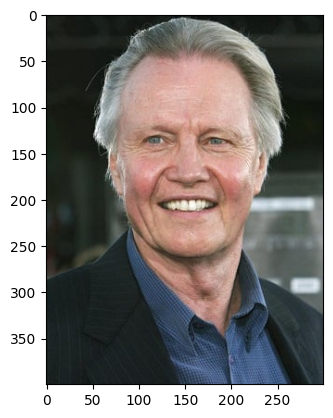

In [7]:
caminho = "vector-databases-intro/imagens/jon-voight/jon-voight-1.jpeg"

imagem = cv2.imread(caminho, cv2.IMREAD_COLOR)
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.imshow(imagem)
plt.show()

O Deepface possui diversos detectores para ser utilizado. Defini o FastMTCNN que demonstrou melhor performance na detecção deste dataset. Geralmente ele é bem robusto com outros.

Para outros detectores, consulte o [repositório](https://github.com/serengil/deepface) do Deepface.

In [12]:
faces = DeepFace.extract_faces(img_path = caminho, detector_backend="fastmtcnn")

O método de extração de faces retorna uma lista das faces detectadas. Na imagem que utilizamos temos apenas uma única face, por isso na lista teremos apenas um único valor no índice 0.

Além da imagem recortada que é armazenada na chave ```face```, temos os dados da área facial (```facial_area```) que determina as coordenadas da face incluindo posicionamento dos olhos. Por fim a precisão da detecção da face, ```confidence```.

In [14]:
faces[0].keys()

dict_keys(['face', 'facial_area', 'confidence'])

In [16]:
faces[0]["facial_area"]

{'x': 78,
 'y': 61,
 'w': 149,
 'h': 196,
 'left_eye': (186, 137),
 'right_eye': (118, 136)}

In [17]:
faces[0]["confidence"]

1.0

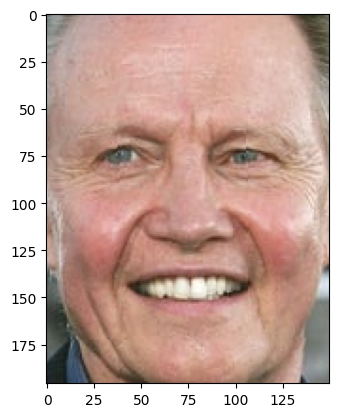

In [18]:
plt.imshow(faces[0]["face"])
plt.show()

## Extração da representação vetorial

Uma vez que conseguimos detectar a face (e normalizá-la), podemos seguir para o próximo passo que é obter os vetores que representam a face.

In [24]:
representacao = DeepFace.represent(img_path = caminho, detector_backend="fastmtcnn")

O retorno é semelhante ao detector. A única diferença é que ao invés de ser retornado a imagem, traz os vetores.

A representação é feita por meio do modelo VGGFace. Este modelo é capaz de representar uma face em 4096 vetores.

In [25]:
representacao[0].keys()

dict_keys(['embedding', 'facial_area', 'face_confidence'])

Tamanho das coordenadas dos vetores.

In [28]:
len(representacao[0]["embedding"])

4096

Abaixo segue os 20 primeiros vetores.

In [27]:
representacao[0]["embedding"][:20]

[0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.13008649196496122,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0,
 0.0]

## Criação de índice no banco de dados

Até agora já sabemos como obter a representação vetorial.
O passo seguinte é criar um índice baseado uma distância apropriada para a busca por vetores semelhantes, ou seja, se uma face se parece mais outros.

Como a face possui uma alta dimensionalidade, vamos utilizar a distância por produto escalar (dot product).

In [36]:
pc = Pinecone(api_key="chave")

In [68]:
pc.create_index(
    name="vgg-face-embedding",
    dimension=4096,
    metric="dotproduct",
    spec=ServerlessSpec(
        cloud="aws",
        region="us-east-1"
    )
)

In [39]:
index = pc.Index("vgg-face-embedding")

index.upsert(
  namespace="joile-faces",
  vectors=[
    {"id": "jon-1", "values": representacao[0]["embedding"], "metadata": {"family": "father"}}
  ]
)

{'upserted_count': 1}

## Inserção dos dados vetorais dos pais

Uma vez que já entendemos cada etapa do processo, vamos criar um algoritmo para inserir todas as imagens no banco de dados.

Começaremos pelo pai, depois a mãe. Ao final, verificaremos uma imagem da filha com quem se parece mais.

In [69]:
arquivos_pai = ["jon-voight-1.jpeg", "jon-voight-1.jpeg", "jon-voight-3.jpg", "jon-voight-4.jpg", "jon-voight-5.jpeg"]
vetores = []

for id, arquivo in enumerate(arquivos_pai):
  representacao = DeepFace.represent(img_path = "vector-databases-intro/imagens/jon-voight/"+arquivo, detector_backend="fastmtcnn")
  vetor = {"id": "jon-"+str(id+1), "values": representacao[0]["embedding"], "metadata": {"family": "father"}}
  vetores.append(vetor)

In [70]:
index = pc.Index("vgg-face-embedding")

index.upsert(
  namespace="joile-family-faces",
  vectors=vetores
)

{'upserted_count': 5}

Vamos agora inserir as da mãe, Marcheline Bertrand.

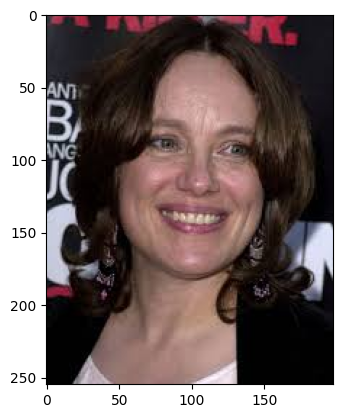

In [43]:
caminho = "vector-databases-intro/imagens/marcheline-bertrand/marcheline-bertrand-1.jpeg"

imagem = cv2.imread(caminho, cv2.IMREAD_COLOR)
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.imshow(imagem)
plt.show()

In [44]:
faces = DeepFace.extract_faces(img_path = caminho, detector_backend="fastmtcnn")

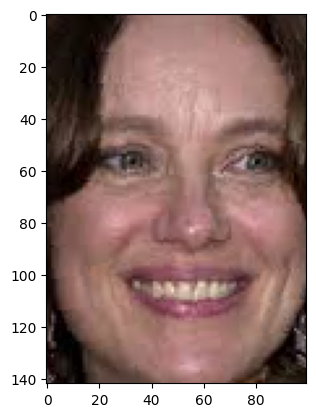

In [45]:
plt.imshow(faces[0]["face"])
plt.show()

In [71]:
arquivos_pai = ["marcheline-bertrand-1.jpeg", "marcheline-bertrand-2.jpeg", "marcheline-bertrand-3.jpeg", "marcheline-bertrand-4.jpeg", "marcheline-bertrand-5.jpg"]
vetores = []

for id, arquivo in enumerate(arquivos_pai):
  representacao = DeepFace.represent(img_path = "vector-databases-intro/imagens/marcheline-bertrand/"+arquivo, detector_backend="fastmtcnn")
  vetor = {"id": "marcheline-"+str(id+1), "values": representacao[0]["embedding"], "metadata": {"family": "mother"}}
  vetores.append(vetor)

In [72]:
index = pc.Index("vgg-face-embedding")

index.upsert(
  namespace="joile-family-faces",
  vectors=vetores
)

{'upserted_count': 5}

## Busca por faces

Vamos buscar qual face é mais similar tendo como referência a Angelina Jolie.

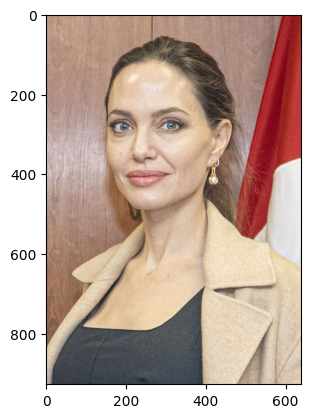

In [73]:
caminho = "vector-databases-intro/imagens/angelina-joile/angelina-jolie-1.jpeg"

imagem = cv2.imread(caminho, cv2.IMREAD_COLOR)
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.imshow(imagem)
plt.show()

In [74]:
faces = DeepFace.extract_faces(img_path = caminho, detector_backend="fastmtcnn")

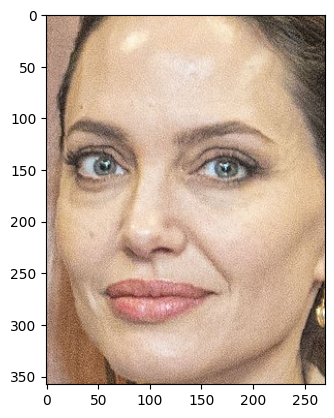

In [75]:
plt.imshow(faces[0]["face"])
plt.show()

In [76]:
representacao = DeepFace.represent(img_path = caminho, detector_backend="fastmtcnn")

Na busca podemos mesclar dados densos (vetores) com esparsos (```metadata```). Com isso é possível separar os scores para cada tipo de familiar.

Vamos começar pelo pai.

In [77]:
index.query(
    namespace="joile-family-faces",
    vector=representacao[0]["embedding"],
    top_k=3,
    include_values=False,
    filter={
        "family": {"$eq": "father"}
    },
    include_metadata=True
)

{'matches': [{'id': 'jon-5',
              'metadata': {'family': 'father'},
              'score': 0.242178664,
              'values': []},
             {'id': 'jon-4',
              'metadata': {'family': 'father'},
              'score': 0.200925305,
              'values': []},
             {'id': 'jon-2',
              'metadata': {'family': 'father'},
              'score': 0.159490913,
              'values': []}],
 'namespace': 'joile-family-faces',
 'usage': {'read_units': 6}}

Agora comparando com a mãe.

In [78]:
index.query(
    namespace="joile-family-faces",
    vector=representacao[0]["embedding"],
    top_k=3,
    include_values=False,
    filter={
        "family": {"$eq": "mother"}
    },
    include_metadata=True
)

{'matches': [{'id': 'marcheline-1',
              'metadata': {'family': 'mother'},
              'score': 0.306281954,
              'values': []},
             {'id': 'marcheline-2',
              'metadata': {'family': 'mother'},
              'score': 0.301963091,
              'values': []},
             {'id': 'marcheline-4',
              'metadata': {'family': 'mother'},
              'score': 0.240892857,
              'values': []}],
 'namespace': 'joile-family-faces',
 'usage': {'read_units': 6}}

Quanto maior score, mais similar é a representação vetorial das faces. É importane notar que a distância euclidiana é o oposto, pela natureza do cálculo.

Os dados mostram que a Angelina Joile é mais parecida com a mãe do que com o pai.

In [79]:
index.query(
    namespace="joile-family-faces",
    vector=representacao[0]["embedding"],
    top_k=3,
    include_values=False
)

{'matches': [{'id': 'marcheline-1', 'score': 0.306281954, 'values': []},
             {'id': 'marcheline-2', 'score': 0.301963091, 'values': []},
             {'id': 'jon-5', 'score': 0.242178664, 'values': []}],
 'namespace': 'joile-family-faces',
 'usage': {'read_units': 5}}

## Identificação por faces

Vamos agora fazer uma busca de uma face que não foi indexada. Este exemplo é para simularmos a busca de uma face e comparando com o que temos em banco de dados.

Aplicações de segurança como busca ou verificação de autenticidade são exemplos que podemos utilizar este método.

Calibre sempre a pontuação com testes de "golden data", para evitar falsos positivos. Ou seja, assumirs que há similaridade quando ela não existe.

O processo é exatamente o mesmo.

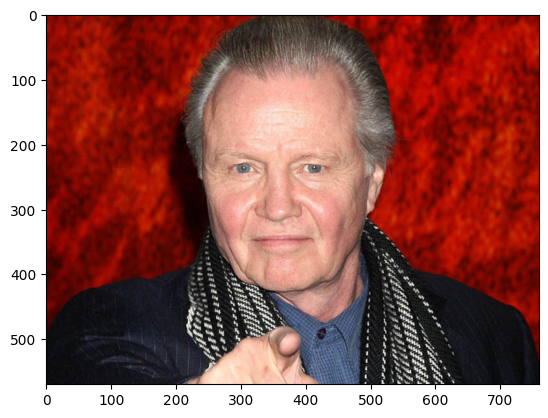

In [80]:
caminho = "vector-databases-intro/imagens/jon-voight/jon-voight-6.jpeg"

imagem = cv2.imread(caminho, cv2.IMREAD_COLOR)
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.imshow(imagem)
plt.show()

In [81]:
faces = DeepFace.extract_faces(img_path = caminho, detector_backend="fastmtcnn")

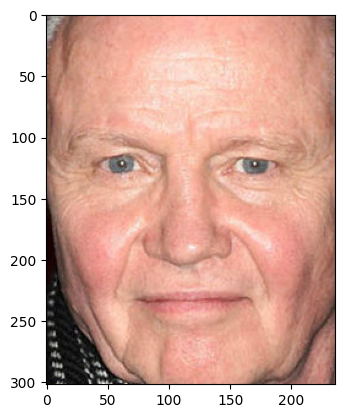

In [82]:
plt.imshow(faces[0]["face"])
plt.show()

In [83]:
representacao = DeepFace.represent(img_path = caminho, detector_backend="fastmtcnn")

In [84]:
index.query(
    namespace="joile-family-faces",
    vector=representacao[0]["embedding"],
    top_k=3,
    include_values=False
)

{'matches': [{'id': 'jon-4', 'score': 0.66914916, 'values': []},
             {'id': 'jon-1', 'score': 0.641483426, 'values': []},
             {'id': 'jon-2', 'score': 0.641483426, 'values': []}],
 'namespace': 'joile-family-faces',
 'usage': {'read_units': 5}}

A busca pela face do Jon Voigh trouxe as 3 faces mais similares. Embora trouxesse as 3, todas elas possuem score bem semelhante.

Vamos fazer agora o mesmo com a Marcheline.

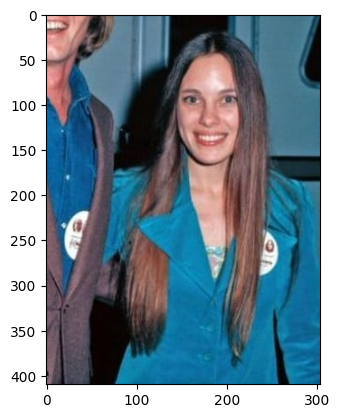

In [85]:
caminho = "vector-databases-intro/imagens/marcheline-bertrand/marcheline-bertrand-6.jpeg"

imagem = cv2.imread(caminho, cv2.IMREAD_COLOR)
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.imshow(imagem)
plt.show()

In [86]:
faces = DeepFace.extract_faces(img_path = caminho, detector_backend="fastmtcnn")

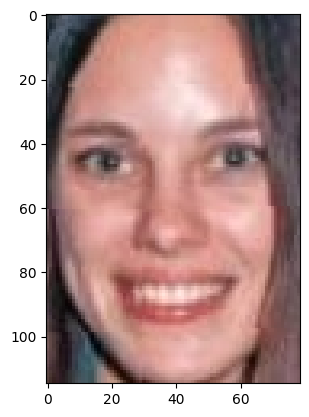

In [87]:
plt.imshow(faces[0]["face"])
plt.show()

In [88]:
representacao = DeepFace.represent(img_path = caminho, detector_backend="fastmtcnn")

In [89]:
index.query(
    namespace="joile-family-faces",
    vector=representacao[0]["embedding"],
    top_k=3,
    include_values=False
)

{'matches': [{'id': 'marcheline-3', 'score': 0.643360496, 'values': []},
             {'id': 'marcheline-2', 'score': 0.550999165, 'values': []},
             {'id': 'marcheline-5', 'score': 0.531142, 'values': []}],
 'namespace': 'joile-family-faces',
 'usage': {'read_units': 5}}

Mesmo com uma foto mais jovem houve similaridade com as fotos mais velhas.

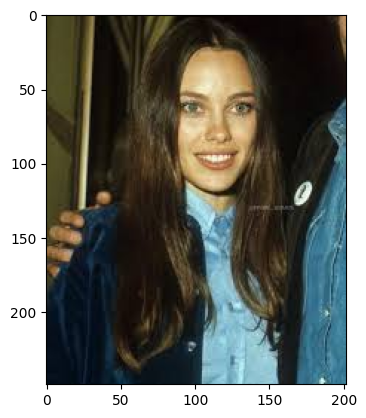

In [90]:
caminho = "vector-databases-intro/imagens/marcheline-bertrand/marcheline-bertrand-3.jpeg"

imagem = cv2.imread(caminho, cv2.IMREAD_COLOR)
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.imshow(imagem)
plt.show()

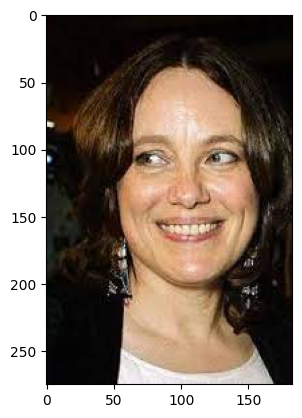

In [91]:
caminho = "vector-databases-intro/imagens/marcheline-bertrand/marcheline-bertrand-2.jpeg"

imagem = cv2.imread(caminho, cv2.IMREAD_COLOR)
imagem = cv2.cvtColor(imagem, cv2.COLOR_BGR2RGB)

plt.imshow(imagem)
plt.show()